<a href="https://colab.research.google.com/github/arampacha/reformer_fastai/blob/master/nbs/exploration/_LM_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Dec 17 22:58:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip install -qq einops axial-positional-embedding fastai datasets
    !pip install -qq git+git://github.com/arampacha/reformer_fastai.git

     |████████████████████████████████| 163kB 17.3MB/s 
     |████████████████████████████████| 17.7MB 212kB/s 
     |████████████████████████████████| 245kB 44.0MB/s 
     |████████████████████████████████| 194kB 12.3MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 


In [ ]:
from fastai.text.all import *
from fastai.basics import *
from datasets import load_dataset
import pdb
import gc

In [ ]:
from reformer_fastai.transformer import TransformerLM
from reformer_fastai.reformer import ReversibleLM
from reformer_fastai.tokenizers import ByteTextTokenizer
from reformer_fastai.metrics import bpc

In [ ]:
!pip install -qqq wandb
!wandb login

In [ ]:
def get_cudas():
    '''Returns the number of tensors in cuda device.'''
    n = 0
    for o in gc.get_objects():
        if torch.is_tensor(o):
            o = maybe_attr(o, 'data')
            if o.is_cuda: n += 1
    return n

# Data

In [ ]:
dataset = load_dataset('tiny_shakespeare')

Using custom data configuration default


Dataset tiny_shakespeare downloaded and prepared to /root/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/da11b9a200ca715af415094b34d5c956170f184cb3a58d7789680cf81bede955. Subsequent calls will reuse this data.


In [ ]:
train_ds = dataset['train']

In [ ]:
def splitlines(sample):
    return {'line':[*sample['text'][0].split('\n')]}

In [ ]:
train_ds = train_ds.map(splitlines, batched=True, remove_columns=['text'])

In [ ]:
train_ds = train_ds.filter(lambda x: x['line'] != '')

In [ ]:
train_ds[:10]

OrderedDict([('line',
              ['First Citizen:',
               'Before we proceed any further, hear me speak.',
               'All:',
               'Speak, speak.',
               'First Citizen:',
               'You are all resolved rather to die than to famish?',
               'All:',
               'Resolved. resolved.',
               'First Citizen:',
               'First, you know Caius Marcius is chief enemy to the people.'])])

In [ ]:
df = train_ds.data.to_pandas()
df.head()

,line
0,First Citizen:
1,"Before we proceed any further, hear me speak."
2,All:
3,"Speak, speak."
4,First Citizen:


In [ ]:
bte = ByteTextTokenizer(is_lm=True, add_bos=True, add_eos=True)

In [ ]:
@patch
def create_item(self:LMDataLoader, seq):
    if seq>=self.n: raise IndexError
    sl = self.last_len if seq//self.bs==self.n_batches-1 else self.seq_len
    st = (seq%self.bs)*self.bl + (seq//self.bs)*self.seq_len
    txt = self.chunks[st : st+sl+1]    
    return LMTensorText(txt[:-1]),txt[1:]
    # return LMTensorText(txt[:-1].tolist()+[1]), LMTensorText(txt[1:].tolist()+[1])   ## ADD EOS TOKEN

In [ ]:
cut = int(len(df)*0.8)
splits = range_of(df)[:cut], range_of(df[cut:])

In [ ]:
tfms = [attrgetter("line"), bte]
dsets = Datasets(df, [tfms, tfms], splits=splits, dl_type=LMDataLoader)

In [ ]:
dsets[0]

(LMTensorText([  2,  73, 108, 117, 118, 119,  35,  70, 108, 119, 108, 125, 104, 113,
          61,   1]),
 LMTensorText([  2,  73, 108, 117, 118, 119,  35,  70, 108, 119, 108, 125, 104, 113,
          61,   1]))

In [ ]:
bs,sl = 32,128
pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])

dls = dsets.dataloaders(bs=bs, seq_len=sl, before_batch=pad_seq2seq)

In [ ]:
dls.show_batch(max_n=2)

,text,text_
0,"<bos>RICHARD:<eos><bos>That brought you forth this boy, to keep your name<eos><bos>Right gracious lord, I cannot brook delay:<eos><bos>Having God, her consc","RICHARD:<eos><bos>That brought you forth this boy, to keep your name<eos><bos>Right gracious lord, I cannot brook delay:<eos><bos>Having God, her consci"
1,"t us<eos><bos>CORIOLANUS:<eos><bos>Peace, I have done. God mark thee to his grace!<eos><bos>Beauty too rich for use, for earth too dear!<eos><bos>Even since it","us<eos><bos>CORIOLANUS:<eos><bos>Peace, I have done. God mark thee to his grace!<eos><bos>Beauty too rich for use, for earth too dear!<eos><bos>Even since it c"


In [ ]:
vocab_sz = bte.vocab_size

# TransformerLM training

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'transformer_lm_test'
GROUP = 'TEST'
NOTES = 'Test TransformerLM on tiny_shakespeare'
CONFIG = {}
TAGS =['lm','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS)

In [ ]:
learn = Learner(dls, TransformerLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, perplexity, bpc]).to_native_fp16()

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.25118863582611084)

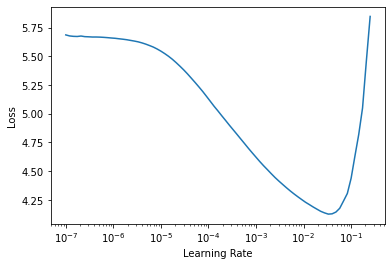

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, 5e-4, wd=0.05, cbs=WandbCallback(log_preds=False, log_model=False))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.988144,2.559395,0.284651,12.927995,00:57
1,2.362572,2.229906,0.350983,9.298993,00:57
2,1.996395,1.839022,0.449633,6.290384,00:57
3,1.757187,1.634609,0.503753,5.127451,00:57
4,1.626100,1.516681,0.534793,4.557075,00:56
5,1.539990,1.442528,0.554723,4.231379,00:56
6,1.483300,1.394562,0.565791,4.033206,00:57
7,1.428262,1.350040,0.579785,3.857580,00:56
8,1.395101,1.310936,0.589967,3.709643,00:58
9,1.364033,1.280257,0.597906,3.597566,00:57


# ReversibleLM training

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'reversible_lm_test'
GROUP = 'TEST'
NOTES = 'Test ReversibleLM on tiny_shakespeare'
CONFIG = {}
TAGS =['lm','test', 'rev']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS)

In [ ]:
learn = Learner(dls, ReversibleLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, perplexity, bpc],
                cbs=TerminateOnNaNCallback()).to_native_fp16()

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=0.0003981071640737355)

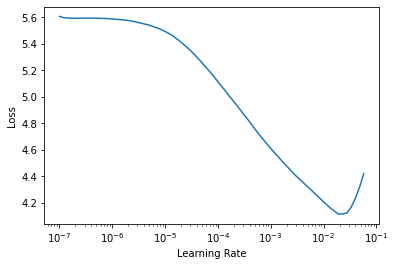

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(15, 5e-4, wd=0.05, cbs=WandbCallback(log_preds=False, log_model=False))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.967855,2.581853,0.279686,13.221617,01:24
1,2.416025,2.284528,0.334542,9.821053,01:24
2,2.094429,1.974309,0.411933,7.201643,01:23
3,1.839166,1.727778,0.479411,5.628135,01:23
4,1.681004,1.588705,0.517141,4.897405,01:23
5,1.593781,1.518977,0.533533,4.567548,01:22
6,1.536284,1.469266,0.545495,4.346044,01:22
7,1.494793,1.426369,0.556746,4.163553,01:23
8,1.458909,1.391739,0.566408,4.021838,01:22
9,1.432291,1.366933,0.573115,3.923298,01:22
